<a href="https://colab.research.google.com/github/rahulsust/quantumcomputing/blob/main/QML/force_field_fitting_using_QML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Quantum Machine Learning Exercise with Qiskit**

This notebook is view-only. Before you code anything, you should make a copy to your google drive via `File` - `Save a copy in Drive`. Otherwise, any code you write here can be run but cannot be saved once you shut down your browser.

**Please do read the instructions**. They contain very useful information to save your time!

## Exercise 2 - Force field fitting

In this exercise, you will need to apply your knowledge from the previous exercise to design a parametric quantum circuit and perform fitting for the energy of a water molecule based on information of the atoms. The key differences to the previous exercise include:

1.   The data set has 3 features instead of 4.
1.   We do not specify a particular circuit structure, rather you should explore different options by yourself. There are some directions to follow, which will be explained.
1.   Each data point is associated with a continuous value instead of a class label, i.e., we have a regression problem instead of a classification problem. The loss function needs to be modified slightly.


The aim is to achieve a loss value as low as possible. As an example, if using mean squared error, a good solution should give error magnitude of $10^{-3}$.

### 1. Install qiskit and other packages

In [ ]:
# In Colab, packages need to be installed when you close and re-open browser
!pip install qiskit
!pip install qiskit-aer
!pip install pylatexenc
!pip install plotly==5.6.0

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 41.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.5/241.5 kB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 51.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.5/37.5 MB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 kB 12.7 MB/s eta 0:00:00
  Created wheel fo

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

### 2. Prepare input data

In this exercise we use the force fields fitting data for hydrogen molecules. It is already in a reduced form, having the three pair-wise relative distances between hydrogen and oxygen atoms computed from their 3-dimensional coordinates. The code to get the dataset is provided, as well as a visualisation. You can play around with the visualisation by dragging with the left/right mouse button and scrolling with the mouse wheel.

In [ ]:
# Get the data files from google drive shared document, so they'll be available as 'local' files
# The downloading may not be successful - try to run the cell repeatedly until you see both downloaded
!gdown https://drive.google.com/uc?id=1DrYpvrbj6k4_VxEZN36IPd2gN6XwDIU4
!gdown https://drive.google.com/uc?id=1BUSqAaS2y6BhsBg7tTkUUnhChCnT85Ft
print()
!ls

Downloading...
From: https://drive.google.com/uc?id=1DrYpvrbj6k4_VxEZN36IPd2gN6XwDIU4
To: /content/H2O.dist.txt
100% 115k/115k [00:00<00:00, 53.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1BUSqAaS2y6BhsBg7tTkUUnhChCnT85Ft
To: /content/H2O.ener.txt
100% 34.0k/34.0k [00:00<00:00, 50.0MB/s]

H2O.dist.txt  H2O.ener.txt  sample_data


In [ ]:
import plotly.graph_objects as go
import plotly.express as px

X, y = np.loadtxt("H2O.dist.txt"), np.loadtxt("H2O.ener.txt")

fig = px.scatter_3d(x=X[:, 0], y=X[:, 1], z=X[:, 2],
        color=y,
        color_continuous_scale =['blue', 'cyan', 'green', 'yellow', 'red'],
        opacity=0.8
)
fig.update_layout(scene = dict(
                    xaxis_title='Distance 0',
                    yaxis_title='Distance 1',
                    zaxis_title='Distance 2',
                    aspectmode='cube'),
                    margin=dict(l=0, r=0, b=0, t=0),
                  coloraxis_colorbar=dict(title="Energy"))
fig.update_traces(marker={'size': 4})
fig.show()

If you rotate the plot to the top view, you can clearly see a nice ring-like pattern.

You should add your code to perform the rescaling. Different to the previous exercise, here you also need to rescale the energy (`y`) values to the range $[0,1]$ because they are continuous and are used when calculating the loss function.

The ratio of training to testing is the same, 0.67:0.33.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
# ------------------------------------------------------------------------------
# Rescale each column in X, and also rescale y
#
# ------------------------------------------------------------------------------
x_scaler = MinMaxScaler(feature_range=(0, np.pi/2))
y_scaler = MinMaxScaler(feature_range=(0, 1))
X = x_scaler.fit_transform(X)
y = y_scaler.fit_transform(y.reshape(-1,1))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### 3. Function to create a parametric quantum circuit

There is no specific circuit that you must implement. You should explore various circuit structures, with any numbers of qubits and gates you like to use.

As a starting point, you may try to use the same circuit structure as in the previous exercise. However, since there are only 3 features instead of 4, you may want to remove the last qubit and the gates acting on it.

This structure may not work very well, so moving forward, you should consider using more combinations of gates, including but not limited to [$R_x$](https://qiskit.org/documentation/stubs/qiskit.circuit.QuantumCircuit.rx.html), [$R_y$](https://qiskit.org/documentation/stubs/qiskit.circuit.QuantumCircuit.ry.html), [$R_z$](https://qiskit.org/documentation/stubs/qiskit.circuit.QuantumCircuit.rx.html), [CNOT](https://qiskit.org/documentation/stubs/qiskit.circuit.QuantumCircuit.cx.html), [CZ](https://qiskit.org/documentation/stubs/qiskit.circuit.QuantumCircuit.cz.html), etc. Any gate available in qiskit can be used to form any circuit structure, as long as it performs well.

You may want to consider the interleaved ansatz, where gates encoding data features $x$ appear not only at the beginning of the circuit, but also repeatedly in the middle of the circuit. A simple way is to extend whatever circuit you already have with a copy, or multiple copies, of itself, with gates encoding $x$ kept the same and gates defined by $\theta$s changed to new $\theta$s. Remember from the lecture that a single-qubit interleaved ansatz that's sufficiently long can learn any function. You are encouraged to try that for this exercise, but it can be more tedious to implement.


In [ ]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import TwoLocal
def create_circuit_with_angles(new_xs, new_thetas):
    """
    Create the parametric circuit with two sets of angles

    Parameters:
        new_xs: np.array(float), should be of length 3
        new_thetas: np.array(float)

    Returns:
        qc_with_fixed_angles: QuantumCircuit, with parameters set to given values
    """

    # --------------------------------------------------------------------------
    # Create a parametric circuit with rotation angles given by arguments
    #
    qc = QuantumCircuit(3,1)
    for i in range(3):
      qc.ry(new_xs[i],i)
    qc.compose(TwoLocal(3, ['ry','rz'], 'cz', 'full', reps=7, insert_barriers=True).decompose().bind_parameters(new_thetas),inplace = True)
    for i in range(3):
      qc.ry(new_xs[i]*(i+2),i)
    qc_with_fixed_angles = qc
    # --------------------------------------------------------------------------

    return qc_with_fixed_angles

It's worth to draw the circuit so you can check the structure.

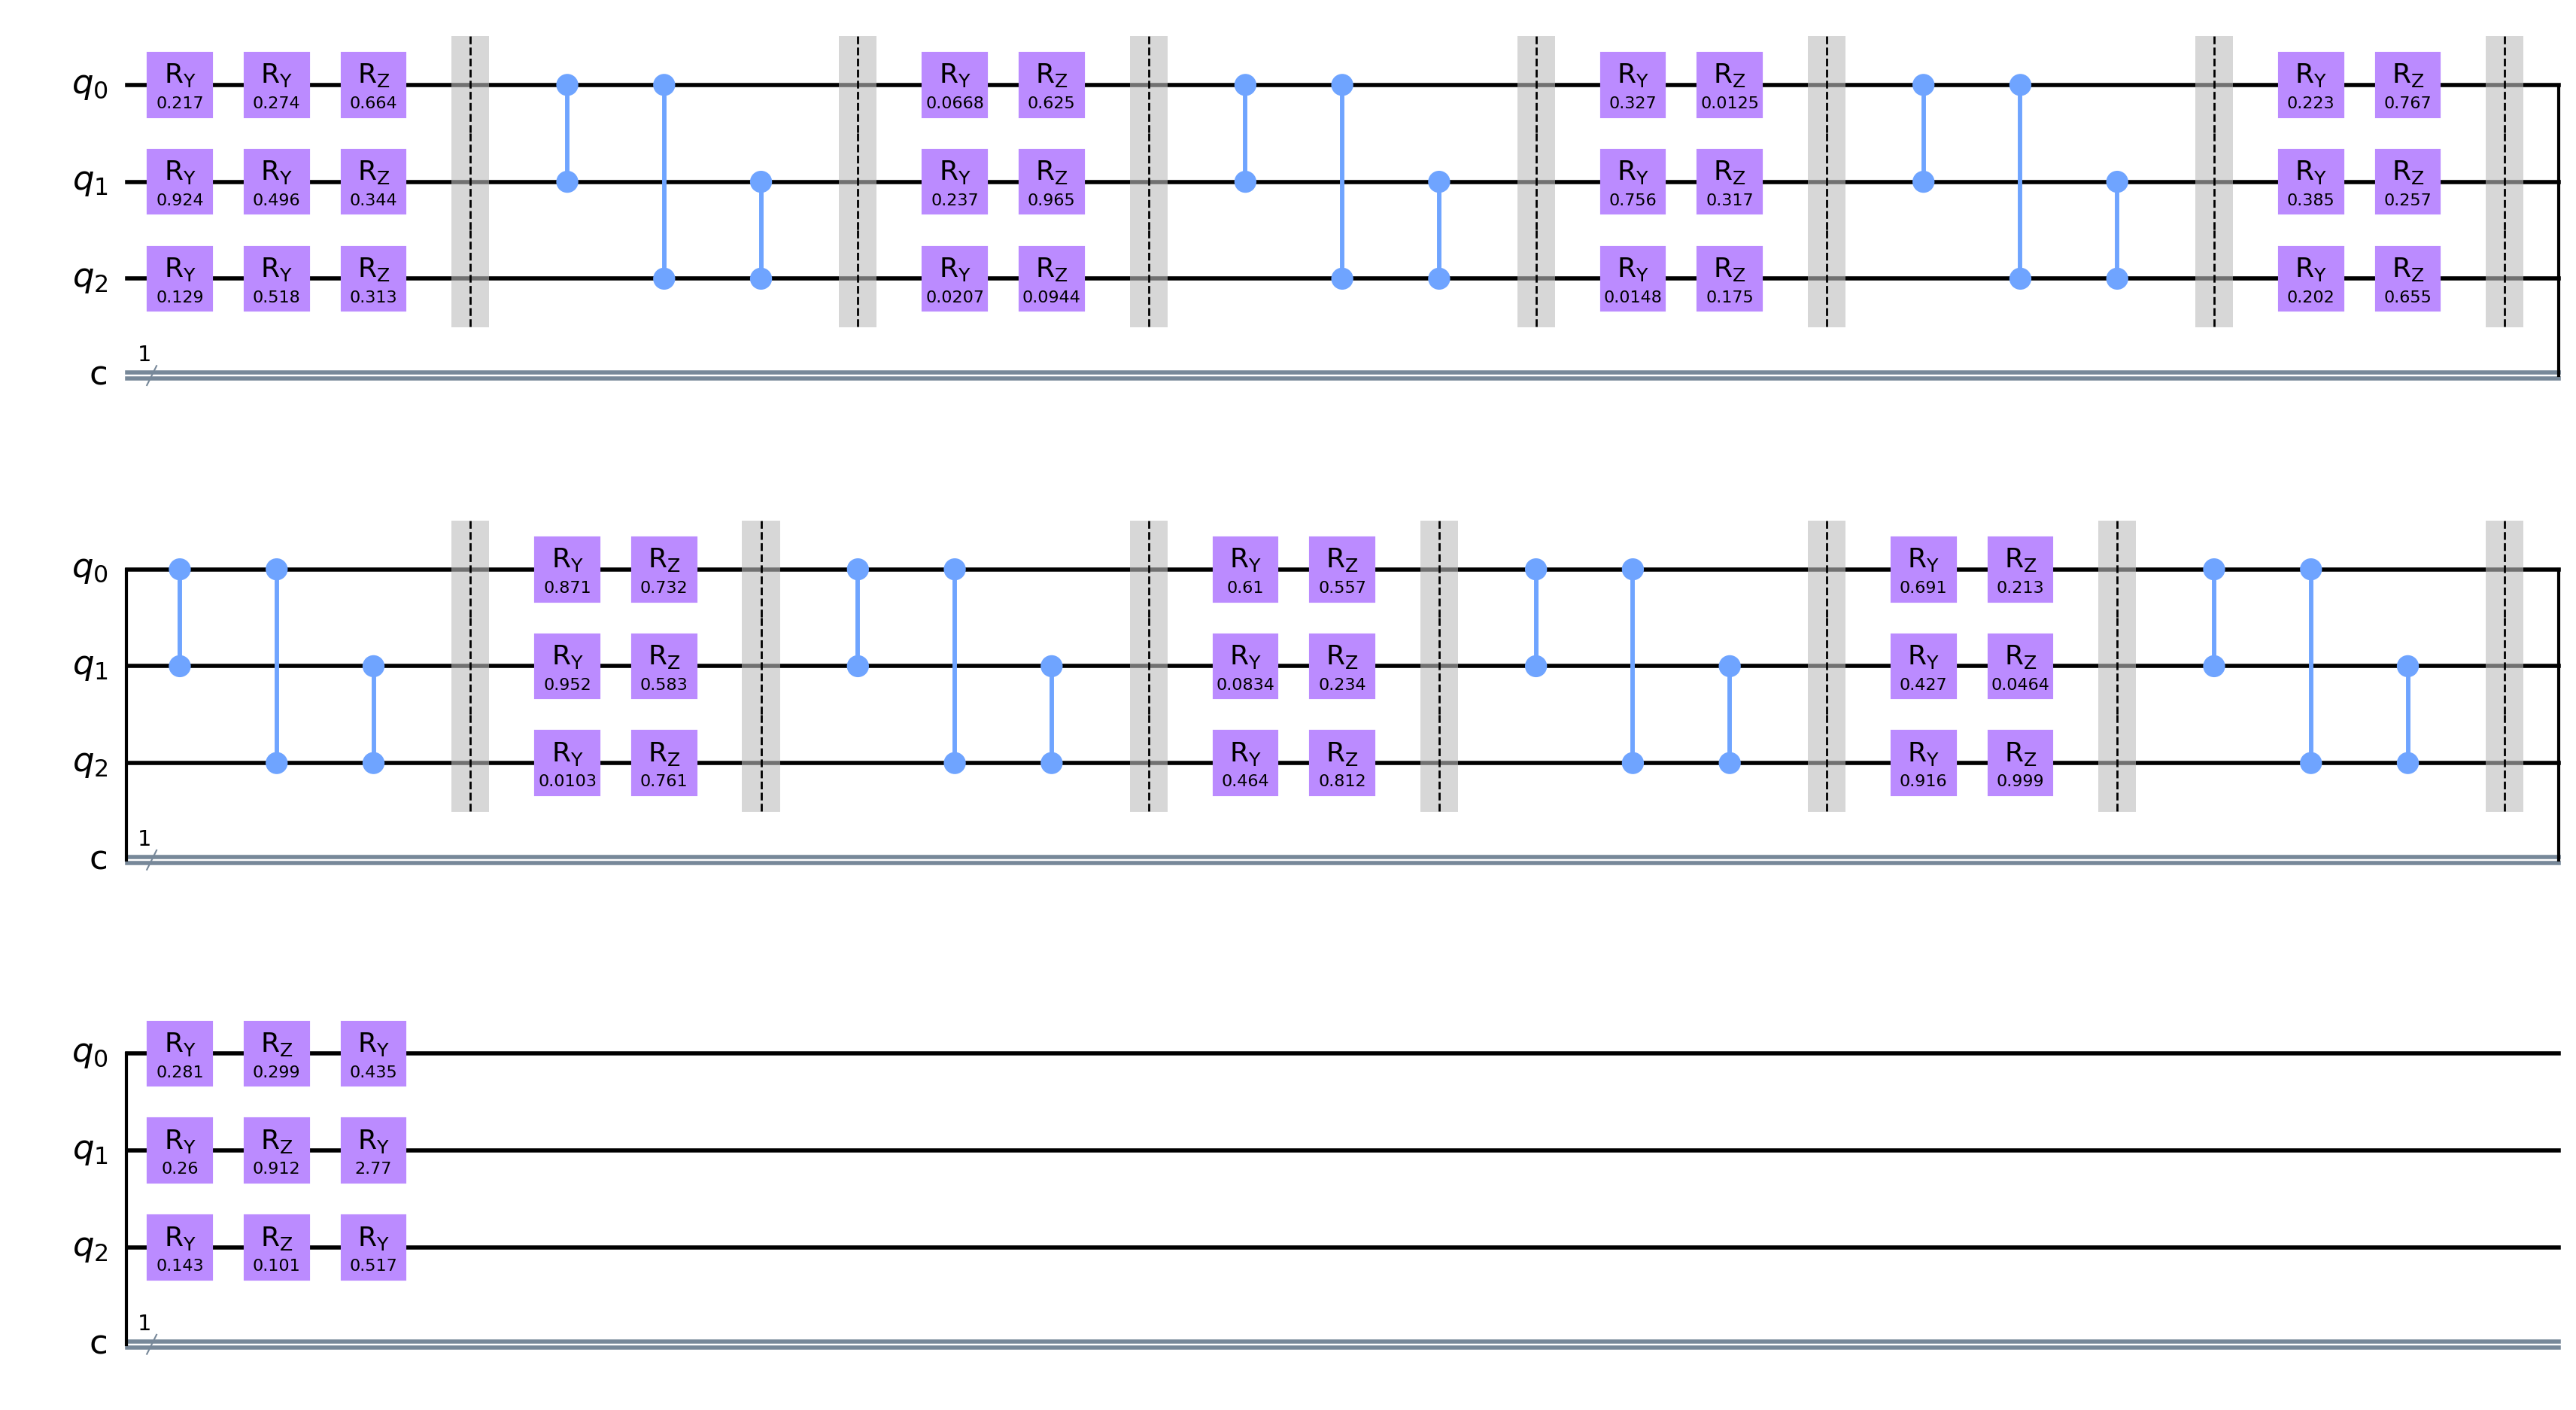

In [ ]:
num_of_thetas = 48  # This depends on your circuit
qc = create_circuit_with_angles(np.random.rand(3), np.random.rand(num_of_thetas))
qc.draw("mpl", scale=2.0)

### 4. Function to get the probability of getting the |0> state upon measurement

Since the force field fitting problem is more difficult, and the focus of this exercise is to explore different circuit structures, we now use the `statevector_simulator` that allows us to access the state vector of the circuit. We can then directly calculate the probabilities of |0> without shot noise.

You need to remove the command `qc.measure(i)` when creating the circuit, otherwise the state vector will collapse. The function to get the probability of |0> on a given qubit index is provided, and you only need to specify the index of the qubit to perform a simulated 'measurement'.

In [ ]:
from qiskit import Aer

simulator = Aer.get_backend('statevector_simulator')

# ------------------------------------------------------------------------------
# Specify simulated measurement index
#
measure_index = 1
# ------------------------------------------------------------------------------


def get_probability_of_zero(qc):
    """
    Parameters:
        qc: QuantumCircuit, which should have a final measurement on one qubit only

    Returns:
        p0: float, the probability of getting |0> on given index
    """

    num_qubits = qc.num_qubits
    if measure_index > num_qubits:
        raise ValueError("Measurement index exceeding number of qubits")

    job = simulator.run(qc)
    sv = np.asarray(job.result().get_statevector())

    p0 = 0
    for i, p in enumerate(sv):
        binary_digit = (i & (1 << (num_qubits - 1 - measure_index))) >> (num_qubits - 1 - measure_index)
        if binary_digit == 0:
            p0 += np.abs(p ** 2)

    return p0


### 5. Function to calculate the loss function

Since the desired value is now a continuous numerical value instead of class labels of 0 and 1, the loss function needs to be modofied or re-designed.

An example loss function would be that we want the probability of getting |0> upon measurement to be close to the rescaled target value, hence the loss is how different they are:
$$
L = (y-p_{(0)})^2
$$

Then the total loss is again the mean of individual loss values. Compared to the mean squared error loss function we used in the previous exercise,  this is even more analogous to the classical MSE.

You are encouraged to try different loss functions.

In [ ]:
def loss_function(thetas, result = False):
    """
    Parameter:
        thetas: np.array(float)

    Returns:
        loss: float
    """

    loss = 0.0
    # --------------------------------------------------------------------------
    # Design a loss function
    #
    for data, label in zip(X_train, y_train):
        qc_with_fixed_angle = create_circuit_with_angles(data,thetas)
        p = [0,0]
        p[0] = get_probability_of_zero(qc_with_fixed_angle)
        p[1] = 1- p[0]
        loss += (p[0]-label)**2
    loss /= len(y_train)
    # --------------------------------------------------------------------------
    if result:
      global epoch
      epoch+=1
      print(f"epoch {epoch} loss {loss}")
    return loss
def call_back(thetas):
  loss_function(thetas,True)

### 6. Minimise the loss function

If you have found a good optimisation method you may continue to use it in this exercise. You may need to change the size of the initial thetas vector.

The optimisation process can be very slow depending on your circuit structure, the number of shots and the optimisation method. Here are ways to obtain quicker results:

1.   Use a reduced training set, e.g., use only 200 training points instead of 0.67*2000
2.   Set a tolerance for the `minimize` function using the argument `tol=<tolerance>`, so the optimisation will terminate if the total loss after one step of update is within the tolerance compared to the previous value
3.   Set a hard limit for the number of `minimize` iterations using the argument `options={"maxiter": <number>}`

These are only meant for quickly trying out things. You should still aim for a loss value as low as possible in the end.

In [ ]:
%%time

from scipy.optimize import minimize

# ------------------------------------------------------------------------------
# Fill in the optimisation method and number of trainable parameters
#
epoch = 0
optimisation_method = "COBYLA"
initial_thetas = np.random.rand(48)
#
# Optional: Reduce training size for quicker results
#
# X_train, y_train = X_train[:200], y_train[:200]
# ------------------------------------------------------------------------------

result = minimize(loss_function, initial_thetas, method=optimisation_method, tol=0.001, options={"maxiter": 12}, callback=call_back)

final_thetas = result.x
print(final_thetas)

epoch 1 loss [0.22099195]
epoch 2 loss [0.25163864]
epoch 3 loss [0.25680273]
epoch 4 loss [0.2636349]
epoch 5 loss [0.09868567]
epoch 6 loss [0.11702597]
epoch 7 loss [0.10557708]
epoch 8 loss [0.04148135]
epoch 9 loss [0.06047168]
epoch 10 loss [0.06942842]
epoch 11 loss [0.06090017]
epoch 12 loss [0.06252734]
epoch 13 loss [0.04148135]
[0.86041606 0.7339739  0.12096604 0.89560462 1.06912487 0.33668533
 0.10307477 1.04910994 0.72735013 0.67514885 0.18782094 0.31476978
 0.58372689 0.99147738 0.58546819 0.30159127 0.26042963 0.2257731
 0.68057674 0.31092962 0.50340985 0.0663263  0.06186845 0.58845993
 0.13195762 0.05840175 0.95266921 0.07697827 0.34353381 0.31262443
 0.7937538  0.26781786 0.38429018 0.05330045 0.42837796 0.98586327
 0.08654509 0.4338108  0.19893864 0.58705183 0.30009693 0.1166846
 0.17657509 0.5559988  0.27602346 0.62506809 0.41984058 0.65465617]
CPU times: user 25min, sys: 6.46 s, total: 25min 7s
Wall time: 25min 23s


### 7. Plot the results

Below we provide code for visualisation. For each set of training/testing/all data points, we plot one graph for the predicted energies and one graph for the mean squared error loss. Note that since we have rescaled the data, the predicted energies now lie in a different range.

You can tell how good your model performs either by looking at if the loss is small enough, or comparing if the 3d visualisations look similar to the given data.

In [ ]:
train_preds, test_preds, total_preds = [], [], []
train_losses, test_losses, total_losses = [], [], []
for all_data, values, preds_list, loss_list, training_or_testing in zip([X_train, X_test, X],
                                        [y_train, y_test, y],
                                        [train_preds, test_preds, total_preds],
                                        [train_losses, test_losses, total_losses],
                                        ["training", "testing", "total"]):
    final_loss = 0
    for data, value in zip(all_data, values):
        probabilities = [0, 0]
        probabilities[0] = get_probability_of_zero(create_circuit_with_angles(data, final_thetas))
        preds_list.append(probabilities[0])
        squared_error_loss = (value - probabilities[0]) ** 2
        loss_list.append(squared_error_loss)
        final_loss += squared_error_loss
    final_loss /= len(all_data)
    print(f"Final {training_or_testing} MSE loss {final_loss}. The first plot is for the predicted energies, the second plot is for the squared error loss values associated to each point")
    preds_list = y_scaler.inverse_transform(np.array(preds_list).reshape(-1,1)).reshape(-1)
    fig = px.scatter_3d(x=all_data[:, 0], y=all_data[:, 1], z=all_data[:, 2],
        color=preds_list,
        color_continuous_scale =['blue', 'cyan', 'green', 'yellow', 'red'],
        opacity=0.8
    )
    fig.update_layout(title=f"Visualisation of {training_or_testing} results",
                      scene = dict(
                        xaxis_title='Distance 0',
                        yaxis_title='Distance 1',
                        zaxis_title='Distance 2',
                        aspectmode='cube'),
                        margin=dict(l=0, r=0, b=0, t=0),
                      coloraxis_colorbar=dict(title="Energy"))
    fig.update_traces(marker={'size': 4})
    fig.show()

    # loss_list[0] = 0
    # loss_list[-1] = 0.1
    loss_list = np.asarray(loss_list).reshape(len(loss_list), 1)
    loss_list = MinMaxScaler(feature_range=(0, 1)).fit_transform(loss_list)
    loss_list = loss_list.reshape(len(loss_list))
    fig = px.scatter_3d(x=all_data[:, 0], y=all_data[:, 1], z=all_data[:, 2],
        color=loss_list,
        color_continuous_scale =['white', 'black'],
        opacity=0.8
    )
    fig.update_layout(title=f"Visualisation of {training_or_testing} results",
                      scene = dict(
                        xaxis_title='Distance 0',
                        yaxis_title='Distance 1',
                        zaxis_title='Distance 2',
                        aspectmode='cube'),
                        margin=dict(l=0, r=0, b=0, t=0),
                      coloraxis_colorbar=dict(title="Squared error loss"))
    fig.update_traces(marker={'size': 4})
    fig.show()

Final training MSE loss [0.04148135]. The first plot is for the predicted energies, the second plot is for the squared error loss values associated to each point


Final testing MSE loss [0.04387114]. The first plot is for the predicted energies, the second plot is for the squared error loss values associated to each point


Final total MSE loss [0.04226998]. The first plot is for the predicted energies, the second plot is for the squared error loss values associated to each point
